#### loading massive ecommerce data from hugging face and then extracging only 2000-3000 rows for cell phones data
hugging face link : https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Go to this link below and find which data you want to load
"https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/review_categories"

In [ ]:
from datasets import load_dataset

# Load directly from the JSONL file in the raw/review_categories directory
datasetCellphones = load_dataset(
    "json",
    data_files="hf://datasets/McAuley-Lab/Amazon-Reviews-2023/raw/review_categories/Cell_Phones_and_Accessories.jsonl"
)
print(datasetCellphones["train"][0])
print(datasetCellphones["train"].column_names)



In [13]:
import pandas as pd
from datasets import load_dataset
import json
from huggingface_hub import hf_hub_download

# 1. Load reviews data
print("Loading reviews data...")
reviews_dataset = load_dataset(
    "json",
    data_files="hf://datasets/McAuley-Lab/Amazon-Reviews-2023/raw/review_categories/Cell_Phones_and_Accessories.jsonl"
)

# 2. Load product metadata using pandas (to avoid schema casting issues)
print("Loading product metadata...")
# Download the file first
metadata_file = hf_hub_download(
    repo_id="McAuley-Lab/Amazon-Reviews-2023",
    filename="raw/meta_categories/meta_Cell_Phones_and_Accessories.jsonl",
    repo_type="dataset"
)

# Read with pandas - handles inconsistent schemas better
metadata_list = []
with open(metadata_file, 'r') as f:
    for line in f:
        metadata_list.append(json.loads(line))

metadata_df = pd.DataFrame(metadata_list)
print(f"✓ Loaded {len(metadata_df):,} product metadata records")

print("\n✓ Data loaded successfully!")
print("="*100)

Loading reviews data...
Loading product metadata...
✓ Loaded 1,288,490 product metadata records

✓ Data loaded successfully!


In [14]:
# 2. Show stats for both datasets
print("\n📊 DATASET STATISTICS")
print("="*100)
print(f"\nReviews Dataset:")
print(f"  - Total reviews: {len(reviews_dataset['train']):,}")
print(f"  - Columns: {reviews_dataset['train'].column_names}")

print(f"\nProduct Metadata Dataset:")
print(f"  - Total products: {len(metadata_df):,}")
print(f"  - Columns: {list(metadata_df.columns)}")
print("="*100)


📊 DATASET STATISTICS

Reviews Dataset:
  - Total reviews: 20,812,945
  - Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Product Metadata Dataset:
  - Total products: 1,288,490
  - Columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author']


In [15]:
# 3. Convert reviews to pandas and merge datasets
print("\n🔄 Converting reviews to pandas DataFrame...")
reviews_df = reviews_dataset["train"].to_pandas()

# Merge reviews with metadata on parent_asin
print("🔗 Merging reviews with product metadata...")
combined_df = reviews_df.merge(
    metadata_df,
    on='parent_asin',
    how='left',
    suffixes=('_review', '_metadata')
)

print(f"✓ Combined dataset created: {len(combined_df):,} records")

# Filter for iPhone products
print("\n🔍 Filtering for iPhone products...")
iphone_df = combined_df[
    (combined_df.get('title_metadata', pd.Series(dtype=str)).fillna('').astype(str).str.contains('iphone', case=False, na=False)) |
    (combined_df['title_review'].fillna('').astype(str).str.contains('iphone', case=False, na=False)) |
    (combined_df['text'].fillna('').astype(str).str.contains('iphone', case=False, na=False))
].copy()

print(f"✓ Found {len(iphone_df):,} iPhone-related reviews")
print("="*100)


🔄 Converting reviews to pandas DataFrame...
🔗 Merging reviews with product metadata...
✓ Combined dataset created: 20,812,945 records

🔍 Filtering for iPhone products...
✓ Found 9,365,841 iPhone-related reviews


In [16]:
# 4. Display top 5 results in tabular format with desired columns
print("\n📋 IPHONE PRODUCTS - TOP 5 RESULTS")
print("="*100)

# Create a clean display dataframe with desired columns
display_df = pd.DataFrame({
    'product_name': iphone_df['title_metadata'],
    'description': iphone_df.get('description', ['N/A'] * len(iphone_df)),
    'price': iphone_df.get('price', ['N/A'] * len(iphone_df)),
    'category': iphone_df.get('categories', ['N/A'] * len(iphone_df)).apply(lambda x: x if isinstance(x, str) else str(x) if x else 'N/A'),
    'rating': iphone_df['rating'],
    'review_title': iphone_df['title_review'],
    'review_text': iphone_df['text']
})

# Set pandas display options for better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.width', None)

# Display first 5 records in tabular format
print(display_df.head(5).to_string(index=True))
print("\n" + "="*100)


📋 IPHONE PRODUCTS - TOP 5 RESULTS
                                                                                                                                                                                               product_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 description  price                                       

/var/folders/mp/cqk_32vx57bfz4y4l7hbdp040000gp/T/ipykernel_88296/2458468162.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


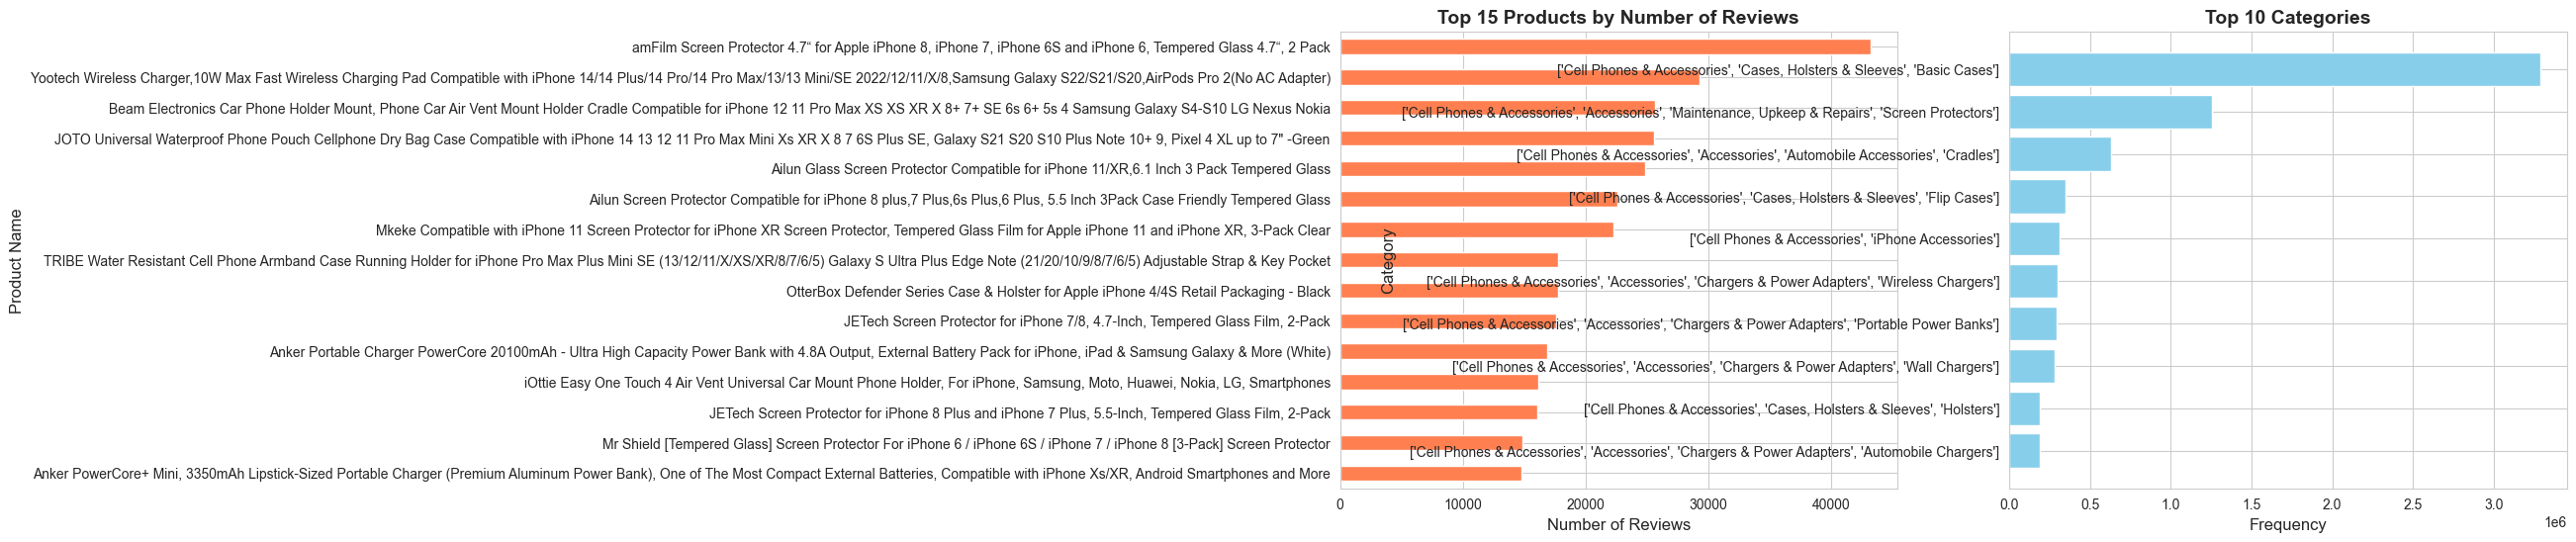


📊 Summary:
Total unique products: 450928
Total reviews: 9365841
Total unique categories: 140


In [22]:
# 5. Data Visualization - Categories and Products Overview
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# 1. Top 15 Products by Review Count
plt.subplot(1, 2, 1)
top_products = display_df['product_name'].value_counts().head(15)
top_products.plot(kind='barh', color='coral')
plt.title('Top 15 Products by Number of Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.gca().invert_yaxis()  # Most popular at top

# 2. Categories Distribution
plt.subplot(1, 2, 2)
# Extract categories (handle if categories is a list or string)
categories_list = []
for cat in display_df['category']:
    if isinstance(cat, list):
        categories_list.extend(cat)
    elif isinstance(cat, str) and cat != 'N/A':
        categories_list.append(cat)

if categories_list:
    from collections import Counter
    category_counts = Counter(categories_list).most_common(10)
    cats = [c[0] for c in category_counts]
    counts = [c[1] for c in category_counts]
    
    plt.barh(cats, counts, color='skyblue')
    plt.title('Top 10 Categories', fontsize=14, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, 'No category data available', 
             ha='center', va='center', fontsize=12)
    plt.title('Categories Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"Total unique products: {display_df['product_name'].nunique()}")
print(f"Total reviews: {len(display_df)}")
if categories_list:
    print(f"Total unique categories: {len(set(categories_list))}")
print("="*100)

In [21]:
# 6. Separate Phones and Accessories into different datasets

# Keywords to identify actual phones vs accessories
phone_keywords = ['iphone 14', 'iphone 13', 'iphone 12', 'iphone 11', 'iphone x', 
                  'iphone se', 'iphone 8', 'iphone 7', 'iphone 6', 'iphone pro', 
                  'iphone max', 'iphone plus', 'iphone mini']

accessory_keywords = ['case', 'cover', 'screen protector', 'charger', 'cable', 
                      'adapter', 'headphone', 'earphone', 'airpod', 'holder', 
                      'stand', 'mount', 'battery', 'power bank', 'skin', 'film']

# Function to classify product
def classify_product(product_name):
    """
    Classify if product is a phone or accessory based on product name
    """
    product_lower = str(product_name).lower()
    
    # Check if it's a phone first (higher priority)
    for keyword in phone_keywords:
        if keyword in product_lower:
            # Make sure it's not an accessory for that phone
            has_accessory_keyword = any(acc in product_lower for acc in accessory_keywords)
            if not has_accessory_keyword:
                return 'phone'
    
    # Check if it's an accessory
    for keyword in accessory_keywords:
        if keyword in product_lower:
            return 'accessory'
    
    # Default: if has "iphone" but no clear category, likely accessory
    return 'accessory'

# Apply classification
display_df['product_type'] = display_df['product_name'].apply(classify_product)

# Create separate datasets
phones_df = display_df[display_df['product_type'] == 'phone'].copy()
accessories_df = display_df[display_df['product_type'] == 'accessory'].copy()

# Show results
print("📱 PHONES vs ACCESSORIES SEPARATION")
print("="*100)
print(f"\nTotal iPhone records: {len(display_df)}")
print(f"  - Phones: {len(phones_df)} ({len(phones_df)/len(display_df)*100:.1f}%)")
print(f"  - Accessories: {len(accessories_df)} ({len(accessories_df)/len(display_df)*100:.1f}%)")
print("\n" + "="*100)

📱 PHONES vs ACCESSORIES SEPARATION

Total iPhone records: 9365841
  - Phones: 264630 (2.8%)
  - Accessories: 9101211 (97.2%)




📱 PHONES DATASET - Sample (Top 3)
                                                                                                                                                                                                product_name  rating                        review_title
2    Keytas Compatible with iPhone XR Screen Replacement Kit 6.1 Inch LCD for iPhone XR 3D Display Touch Screen Digitizer Full Assembly with Tools Kit+ Screen Tempered Protector+ Waterproof Frame Adhesive     5.0  Worked but took an hour to install
270                  Fugetek 48" Compact Selfie Stick & Tripod, Extendable, Wireless Bluetooth Remote, Lightweight Aluminum, Travel Ready, Compatible with iPhone 14 13 12 Pro Xs Max Xr X 8Plus 7 & Android     2.0                        selfie stick
514                                                                                                                            ykooe Cell Phone Holster for iPhone 14 Pro Max, iPhone 13 Pro Max, Black – XL     3.0      

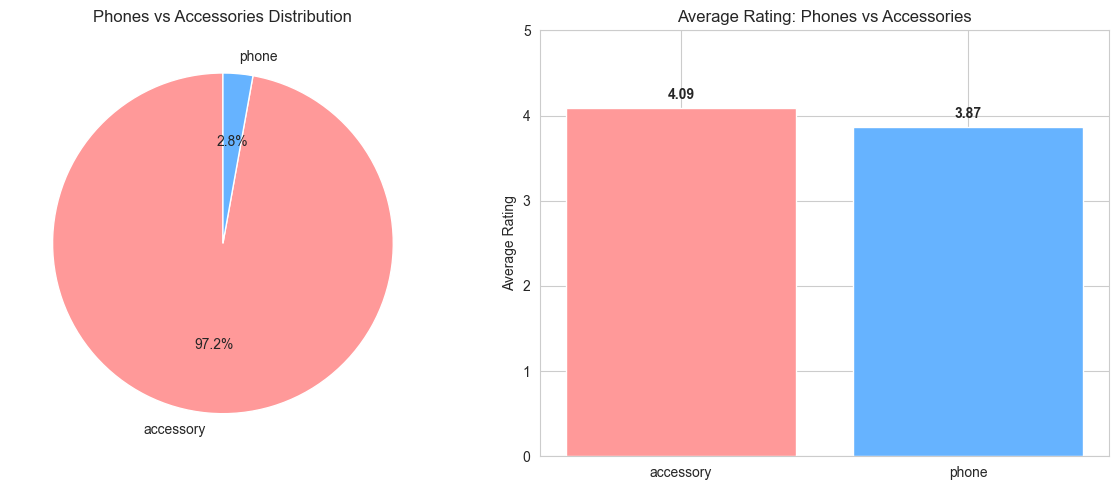


✓ Datasets created successfully!
  - phones_df: 264630 records
  - accessories_df: 9101211 records


In [23]:
# 7. Display sample data from Phones and Accessories datasets

print("\n📱 PHONES DATASET - Sample (Top 3)")
print("="*100)
print(phones_df[['product_name', 'rating', 'review_title']].head(3).to_string(index=True))

print("\n\n🎧 ACCESSORIES DATASET - Sample (Top 3)")
print("="*100)
print(accessories_df[['product_name', 'rating', 'review_title']].head(3).to_string(index=True))

# Visualize the distribution
plt.figure(figsize=(12, 5))

# Product type distribution
plt.subplot(1, 2, 1)
product_counts = display_df['product_type'].value_counts()
plt.pie(product_counts, labels=product_counts.index, autopct='%1.1f%%', 
        colors=['#ff9999', '#66b3ff'], startangle=90)
plt.title('Phones vs Accessories Distribution')

# Average rating comparison
plt.subplot(1, 2, 2)
avg_ratings = display_df.groupby('product_type')['rating'].mean()
plt.bar(avg_ratings.index, avg_ratings.values, color=['#ff9999', '#66b3ff'])
plt.title('Average Rating: Phones vs Accessories')
plt.ylabel('Average Rating')
plt.ylim(0, 5)
for i, v in enumerate(avg_ratings.values):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Datasets created successfully!")
print(f"  - phones_df: {len(phones_df)} records")
print(f"  - accessories_df: {len(accessories_df)} records")
print("="*100)

In [24]:
# 8. Create random sample dataset with 2000-3000 records

# Set random seed for reproducibility
import random
random.seed(42)

# Create a random sample of 2500 records from display_df
sample_size = 2500
sample_df = display_df.sample(n=min(sample_size, len(display_df)), random_state=42)

print(f"📦 SAMPLE DATASET CREATED")
print("="*100)
print(f"Original dataset size: {len(display_df)}")
print(f"Sample dataset size: {len(sample_df)}")
print("\n" + "="*100)

# Print column names
print(f"\n📋 Column Names:")
print(sample_df.columns.tolist())
print("\n" + "="*100)

# Print first 10 records
print(f"\n🔍 First 10 Records:")
print("="*100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.width', None)
print(sample_df.head(10).to_string(index=True))
print("\n" + "="*100)

📦 SAMPLE DATASET CREATED
Original dataset size: 9365841
Sample dataset size: 2500


📋 Column Names:
['product_name', 'description', 'price', 'category', 'rating', 'review_title', 'review_text', 'review_length', 'product_type']


🔍 First 10 Records:
                                                                                                                                                                                                      product_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [25]:
# 9. Explore all categories to find phone-specific categories

print("🔍 CATEGORY ANALYSIS")
print("="*100)

# Extract all unique categories from display_df
all_categories = []
category_to_products = {}  # Track which products are in each category

for idx, row in display_df.iterrows():
    cat = row['category']
    product_name = str(row['product_name']).lower()
    
    # Handle different category formats (list, string, etc.)
    if isinstance(cat, list):
        for c in cat:
            all_categories.append(c)
            if c not in category_to_products:
                category_to_products[c] = []
            category_to_products[c].append(product_name)
    elif isinstance(cat, str) and cat != 'N/A':
        all_categories.append(cat)
        if cat not in category_to_products:
            category_to_products[cat] = []
        category_to_products[cat].append(product_name)

# Get unique categories with counts
from collections import Counter
category_counts = Counter(all_categories)

print(f"\nTotal unique categories: {len(category_counts)}\n")
print("="*100)

# Display all categories with their counts
print("\n📋 ALL CATEGORIES (sorted by frequency):\n")
for category, count in category_counts.most_common():
    print(f"  {category}: {count} products")

print("\n" + "="*100)

# Analyze which categories likely contain actual phones
print("\n📱 CATEGORIES LIKELY CONTAINING PHONES:\n")
phone_categories = []

for category, products in category_to_products.items():
    # Check if products in this category mention phone models (not accessories)
    phone_product_count = 0
    accessory_product_count = 0
    
    for product in products:
        # Check if it's an actual phone
        if any(model in product for model in ['iphone 14', 'iphone 13', 'iphone 12', 'iphone 11', 'iphone x', 'iphone se']):
            # Make sure it's not an accessory
            if not any(acc in product for acc in ['case', 'cover', 'protector', 'charger', 'cable']):
                phone_product_count += 1
        # Check if it's an accessory
        if any(acc in product for acc in ['case', 'cover', 'protector', 'charger', 'cable', 'adapter']):
            accessory_product_count += 1
    
    if phone_product_count > 0:
        phone_ratio = phone_product_count / len(products) * 100
        phone_categories.append((category, phone_product_count, len(products), phone_ratio))

# Sort by phone ratio
phone_categories.sort(key=lambda x: x[3], reverse=True)

for cat, phone_count, total_count, ratio in phone_categories:
    print(f"  {cat}")
    print(f"    - Phone products: {phone_count}/{total_count} ({ratio:.1f}%)")
    print()

print("="*100)

🔍 CATEGORY ANALYSIS

Total unique categories: 140


📋 ALL CATEGORIES (sorted by frequency):

  ['Cell Phones & Accessories', 'Cases, Holsters & Sleeves', 'Basic Cases']: 3285109 products
  ['Cell Phones & Accessories', 'Accessories', 'Maintenance, Upkeep & Repairs', 'Screen Protectors']: 1257637 products
  ['Cell Phones & Accessories', 'Accessories', 'Automobile Accessories', 'Cradles']: 631266 products
  ['Cell Phones & Accessories', 'Cases, Holsters & Sleeves', 'Flip Cases']: 347513 products
  ['Cell Phones & Accessories', 'iPhone Accessories']: 310805 products
  ['Cell Phones & Accessories', 'Accessories', 'Chargers & Power Adapters', 'Wireless Chargers']: 299115 products
  ['Cell Phones & Accessories', 'Accessories', 'Chargers & Power Adapters', 'Portable Power Banks']: 297289 products
  ['Cell Phones & Accessories', 'Accessories', 'Chargers & Power Adapters', 'Wall Chargers']: 281804 products
  ['Cell Phones & Accessories', 'Cases, Holsters & Sleeves', 'Holsters']: 193113 products

In [26]:
# Print all unique categories from display_df

print("📋 ALL AVAILABLE CATEGORIES")
print("="*100)

# Collect all categories
all_categories = set()

for cat in display_df['category']:
    if isinstance(cat, list):
        # If category is a list, add each item
        for c in cat:
            all_categories.add(c)
    elif isinstance(cat, str) and cat != 'N/A':
        # If category is a string, add it
        all_categories.add(cat)

# Sort and print
all_categories = sorted(all_categories)

print(f"\nTotal unique categories: {len(all_categories)}\n")

for i, category in enumerate(all_categories, 1):
    print(f"{i}. {category}")

print("\n" + "="*100)

📋 ALL AVAILABLE CATEGORIES

Total unique categories: 140

1. ['Cell Phones & Accessories', '$100 Amazon Gift Card for Hotspots']
2. ['Cell Phones & Accessories', 'Accessories', 'Adhesive Card Holders']
3. ['Cell Phones & Accessories', 'Accessories', 'Automobile Accessories', 'Cradles']
4. ['Cell Phones & Accessories', 'Accessories', 'Automobile Accessories', 'Kits']
5. ['Cell Phones & Accessories', 'Accessories', 'Automobile Accessories', 'Pads & Mats']
6. ['Cell Phones & Accessories', 'Accessories', 'Automobile Accessories', 'Speakerphones']
7. ['Cell Phones & Accessories', 'Accessories', 'Automobile Accessories']
8. ['Cell Phones & Accessories', 'Accessories', 'Cables & Adapters', 'OTG Adapters']
9. ['Cell Phones & Accessories', 'Accessories', 'Cables & Adapters']
10. ['Cell Phones & Accessories', 'Accessories', 'Chargers & Power Adapters', 'Automobile Chargers']
11. ['Cell Phones & Accessories', 'Accessories', 'Chargers & Power Adapters', 'Charging Stations']
12. ['Cell Phones & Acc

In [29]:
# Filter only actual phones (exclude accessories)

# Accessory keywords to exclude
accessory_keywords = ['case', 'cover', 'protector', 'screen protector', 'charger', 
                      'cable', 'adapter', 'holder', 'stand', 'mount', 'skin', 
                      'film', 'tempered glass', 'wallet', 'pouch', 'sleeve',
                      'earphone', 'headphone', 'airpod', 'earbud', 'power bank',
                      'battery pack', 'ring', 'grip', 'strap', 'armband', 'belt clip']

# Phone keywords (actual devices)
phone_keywords = ['iphone 15', 'iphone 14', 'iphone 13', 'iphone 12', 'iphone 11', 
                  'iphone x', 'iphone xs', 'iphone xr', 'iphone se', 'iphone 8', 
                  'iphone 7', 'iphone 6', 'iphone pro', 'iphone pro max', 'iphone plus']

def is_actual_phone(product_name):
    """Check if product is an actual phone (not an accessory)"""
    name_lower = str(product_name).lower()
    
    # Step 1: Check if it contains phone keywords
    has_phone = any(phone in name_lower for phone in phone_keywords)
    
    # Skip if no phone keyword found
    if not has_phone:
        return False
    
    # Step 2: Check if it contains any accessory keywords
    has_accessory = any(acc in name_lower for acc in accessory_keywords)
    
    # Skip if it's an accessory
    if has_accessory:
        return False
    
    # Step 3: Check if it has "GB" (storage capacity = actual phone)
    has_gb = 'gb' in name_lower
    
    # It's a phone only if it has "GB" keyword
    return has_gb

# Apply filter
phones_only_df = display_df[display_df['product_name'].apply(is_actual_phone)].copy()

print("📱 PHONES ONLY (Accessories Excluded)")
print("="*100)
print(f"\nOriginal records: {len(display_df)}")
print(f"Phones only: {len(phones_only_df)}")
print(f"Filtered out: {len(display_df) - len(phones_only_df)} accessories")

print("\n" + "="*100)
print("\n🔍 Sample phone products (first 10):\n")
for i, name in enumerate(phones_only_df['product_name'].head(10), 1):
    print(f"{i}. {name}")

print("\n" + "="*100)

📱 PHONES ONLY (Accessories Excluded)

Original records: 9365841
Phones only: 53401
Filtered out: 9312440 accessories


🔍 Sample phone products (first 10):

1. Apple iPhone 11 Pro, 64GB, Midnight Green - Unlocked (Renewed)
2. Apple iPhone XR, US Version, 64GB, Black - AT&T (Renewed)
3. Apple iPhone 11 Pro, 64GB, Midnight Green - Unlocked (Renewed)
4. Apple iPhone 6 Plus 64 GB Factory Unlocked, Silver
5. Apple iPhone XS Max, US Version, 256GB, Gold - AT&T (Renewed)
6. Apple iPhone XS Max, US Version, 256GB, Gold - AT&T (Renewed)
7. Apple iPhone X, US Version, 256GB, Silver - AT&T (Renewed)
8. Apple iPhone XR, US Version, 64GB, Black - AT&T (Renewed)
9. Apple iPhone XR, US Version, 64GB, Black - AT&T (Renewed)
10. Apple iPhone XR, US Version, 64GB, Black - AT&T (Renewed)



In [30]:
# Create CSV with selected columns from phones_only_df (2000-3000 records)

# Select required columns
columns_needed = ['product_name', 'description', 'price', 'rating', 'review_title', 'review_text']

# Filter columns that exist
available_columns = [col for col in columns_needed if col in phones_only_df.columns]
print(f"Available columns: {available_columns}")

# Create subset with selected columns
phones_csv_df = phones_only_df[available_columns].copy()

# Get random sample of 2500 records (between 2000-3000)
sample_size = min(2500, len(phones_csv_df))
phones_sample_df = phones_csv_df.sample(n=sample_size, random_state=42)

# Save to CSV
csv_path = '../data/phones_reviews.csv'
phones_sample_df.to_csv(csv_path, index=False)

print("\n📁 CSV FILE CREATED")
print("="*100)
print(f"\nFile saved: {csv_path}")
print(f"Total records: {len(phones_sample_df)}")
print(f"Columns: {list(phones_sample_df.columns)}")

print("\n" + "="*100)
print("\n🔍 Preview (first 5 rows):\n")
print(phones_sample_df.head().to_string(index=True))
print("\n" + "="*100)

Available columns: ['product_name', 'description', 'price', 'rating', 'review_title', 'review_text']

📁 CSV FILE CREATED

File saved: ../data/phones_reviews.csv
Total records: 2500
Columns: ['product_name', 'description', 'price', 'rating', 'review_title', 'review_text']


🔍 Preview (first 5 rows):

                                                                product_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  price  rating                review_title                                                                                